# NESP: 14656 Unique Mutations + Voxel Features + PDBs

This notebook compiles together 8 datasets and generates voxel features that can later be used to train 3D CNN models for protein stability detection. The following source databases were used to generate the resulting dataset:

* [ThermoMutDB](http://biosig.unimelb.edu.au/thermomutdb)
* [iStable2.0](http://ncblab.nchu.edu.tw/iStable2/)
* [dt-xgboost-5000-mutations-200-pdb-files-lb-0-40](https://www.kaggle.com/code/cdeotte/xgboost-5000-mutations-200-pdb-files-lb-0-40)
* [S1626](https://aip.scitation.org/doi/suppl/10.1063/1.4947493)
* [S140](http://marid.bioc.cam.ac.uk/sdm2/data)
* [S2648](http://marid.bioc.cam.ac.uk/sdm2/data)
* [Q3214, Q1744](https://github.com/gersteinlab/ThermoNet/tree/master/data/datasets)
* [Q3421](https://github.com/gersteinlab/ThermoNet/tree/master/data/datasets)
* [FireProtDB (6713 mutations)](https://loschmidt.chemi.muni.cz/fireprotdb/)


There is a significant overlap between datasets above. Unique mutations can be described with the following unique triplets `(fasta_sequence, pdb_mutation_position, mutant_residue)`. The final dataset generated by this notebook contains 14656 such unique triplets. AFAIK at the time of publishing (26.10) this is the largest published NESP dataset by number of unique single mutations!

Description of the resulting dataset:
* **dataset.csv** - single mutation data deduplicated by protein sequence. 
* **features** - a folder with a list of numpy files, one per mutation. See [NESP: ThermoNet v2](https://www.kaggle.com/code/vslaykovsky/nesp-thermonet-v2) on how to use it


Example model using this dataset is [NESP: [LB:0.518] ThermoNet v2](https://www.kaggle.com/vslaykovsky/nesp-thermonet-v2). 
The dataset helped to push LB of the ThermoNet model from 0.4 to **0.48**!


## Updates
1. Thanks @cdeotte for pointing out that some models benefit from sequence position information. Adding `seq_position` field in this update. 
2. Also adding **relaxed PDB files of wildtypes and mutants** to the output.
3. Added ThermoMutDB and iStable2.0 datasets to grow the dataset **9929->14656**, reworked the notebook to bring more clarity. 

## Limitations
**Note** that some of the code in this notebook is disabled under `DOCKER, RUN_FAST_RELAX, RUN_MUTANT_FAST_RELAX, GEN_FEATURES` conditions. Instead the pre-cached version of outputs from `../input/cache-for-9936-unique-mutations-notebook` is used. This is because of the following constraints:
* Some job require a lot of CPU capacity and would take many days to run in a single Kaggle notebook. So I provide example docker code to illustrate how the cached data was generated. 
* Rosetta is available under an academic license that prevents it to be distributed in Kaggle datasets. So I'm not able to share and run Rosetta binaries here. 
* HTMD library requires registration before the first use. 

# Utils, imports

In [71]:
DOCKER = False  # requires Docker
RUN_FAST_RELAX = False  # requires Rosetta
RUN_MUTANT_FAST_RELAX = False  # requires Rosetta
GEN_FEATURES = False  # requires HTMD

import glob
import os
import warnings
import numpy as np
import Bio
import pandas as pd
import requests
from Bio import SeqUtils
from Bio.PDB import PDBParser, PDBIO
from Bio.SeqUtils import seq1
from tqdm import tqdm
from tqdm.notebook import tqdm
import json
import re

pd.set_option('display.max_columns', 1000)

THERMONET_V1 = 'ThermoNetV1'

COLUMNS = ['sequence', 'PDB_chain', 'PDB', 'chain', 'wildtype', 'seq_position', 'pdb_position', 'mutant', 'ddG', 'dT', 'wT', 'pH', 'source']

DATASETS_PATH='data/thermonet'

try:

    import kaggle_secrets
    print('Running in Kaggle')

    !pip install crc64iso
    from crc64iso import crc64iso
    
    !ln -s ../input/cache-for-9936-unique-mutations-notebook/data/data /kaggle/working/data
    !cp -r ../input/thermonet-src-jobs/* .
    

    
    CLEAN = True
    KAGGLE = True
except Exception as ex:
    print('Running locally')

    ROSETTA_BIN = f'{os.getcwd()}/rosetta/rosetta_bin_linux_2018.33.60351_bundle/main/source/bin'

    DOCKER = True
    CLEAN = False
    KAGGLE = False

Running locally


In [2]:
! pip install biopython==1.79

In [3]:
import matplotlib.pyplot as plt


def plot_hist(df):
    plt.figure(figsize=(20, 7))
    if 'ddG' in df.columns:
        df.ddG.plot.hist(bins=50, ax=plt.subplot(1, 3, 1), title='ddG distribution')
    if 'dT' in df.columns:
        df.dT.plot.hist(bins=50, ax=plt.subplot(1, 3, 2), title='dT distribution')
    if 'dT' in df.columns and 'ddG' in df.columns:
        df.plot.scatter(x='ddG', y='dT', ax=plt.subplot(1, 3, 3), title='ddG vs dT')
    

# Combined Datasets

## [FireProtDB](https://loschmidt.chemi.muni.cz/fireprotdb/)

In [4]:
def load_fireprot():
    df = pd.read_csv(f'{DATASETS_PATH}/datasets/fireprotdb_results.csv').drop_duplicates()
    df = df.dropna(subset=['pdb_id']).reset_index(drop=True)  # Invalid PDB structures, we use AF2 structures in FireProtDB
    df = df.rename(columns={'wild_type': 'wildtype', 'position': 'pdb_position', 'mutation': 'mutant', 'dTm': 'dT'})
    df['source'] = 'FireProtDB'
    df.ddG = -df.ddG
    return df.filter(COLUMNS)


df = load_fireprot()
df

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (23,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


,sequence,chain,wildtype,pdb_position,mutant,ddG,dT,pH,source
0,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,A,V,245,L,NaN,2.1,NaN,FireProtDB
1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,A,L,95,V,NaN,-0.4,NaN,FireProtDB
2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,A,C,176,F,NaN,5.2,NaN,FireProtDB
3,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,A,G,171,Q,NaN,3.1,NaN,FireProtDB
4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,A,T,148,L,NaN,1.1,NaN,FireProtDB
...,...,...,...,...,...,...,...,...,...
15967,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,A,M,104,K,0.6,NaN,NaN,FireProtDB
15968,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,A,M,134,A,-2.2,NaN,NaN,FireProtDB
15969,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,A,M,134,G,-7.0,NaN,NaN,FireProtDB
15970,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,A,M,134,I,-2.1,NaN,NaN,FireProtDB


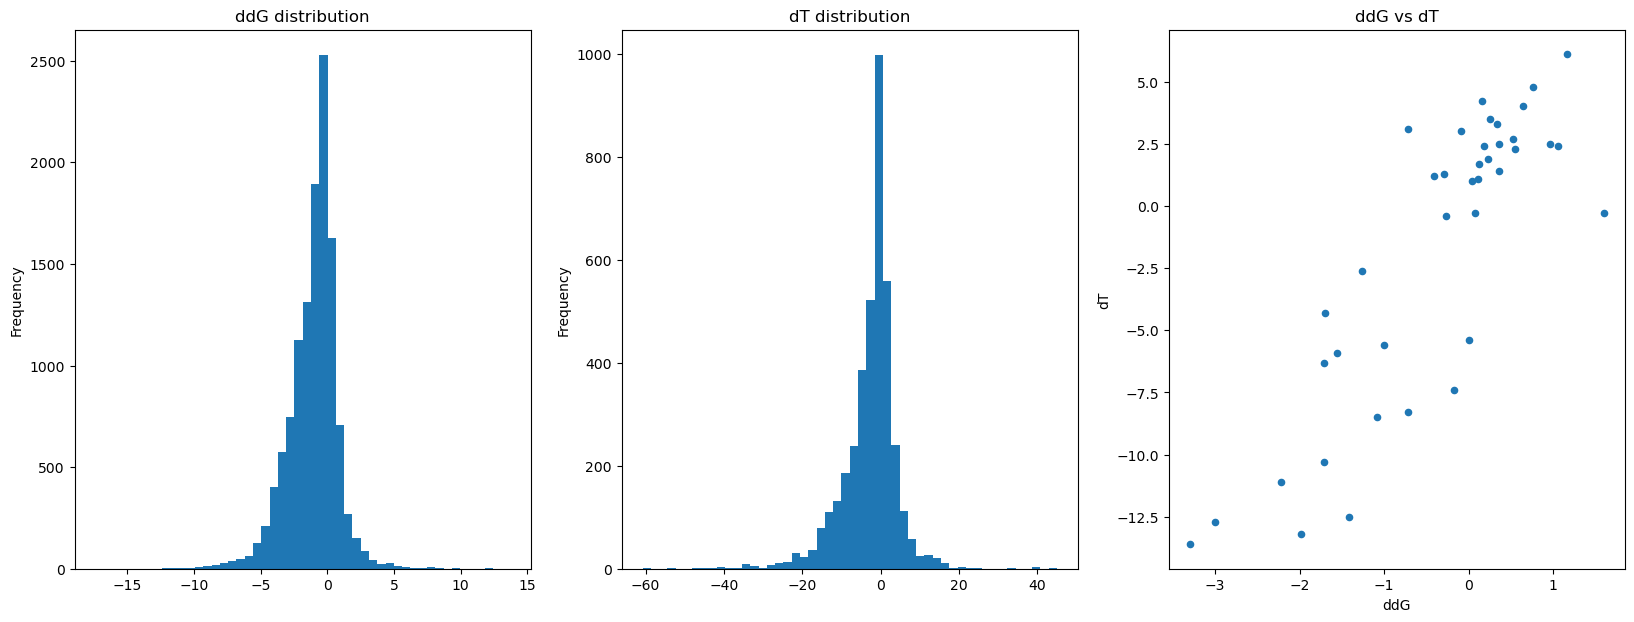

In [5]:
plot_hist(df)

## [iStable2.0](http://ncblab.nchu.edu.tw/iStable2/)

In [6]:
def load_s630():
    df = pd.DataFrame(pd.read_csv(f'{DATASETS_PATH}/S630.txt', sep="\t"))
    COLUMNS = ['sequence', 'PDB_chain', 'PDB', 'chain', 'wildtype', 'seq_position', 'pdb_position', 'mutant', 'ddG', 'dT', 'wT', 'pH', 'source']
    df = df.rename(columns={
        'WT': 'wildtype',
        'Position': 'pdb_position',
        # 'Seq_position': 'seq_position', # seq positions are invalid
        'Mutation': 'mutant',
        'actual_ddG': 'ddG',
    })
    df.PDB = df.PDB.str.lower()
    df['source'] = 'iStable2.0 - s630'
    return df.filter(COLUMNS)

df = load_s630()
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,pH,source
0,1ag2,A,M,129,V,-0.33,7.0,iStable2.0 - s630
1,1ag2,A,V,180,I,-0.50,7.0,iStable2.0 - s630
2,1ag2,A,T,183,A,-4.62,7.0,iStable2.0 - s630
3,1ag2,A,T,190,V,-0.17,7.0,iStable2.0 - s630
4,1ag2,A,F,198,S,-2.46,7.0,iStable2.0 - s630
...,...,...,...,...,...,...,...,...
625,3mbp,A,P,159,A,-1.80,7.4,iStable2.0 - s630
626,3mbp,A,P,159,S,-2.10,7.4,iStable2.0 - s630
627,3mbp,A,A,276,G,-1.50,7.6,iStable2.0 - s630
628,3mbp,A,Y,283,D,-3.20,7.6,iStable2.0 - s630


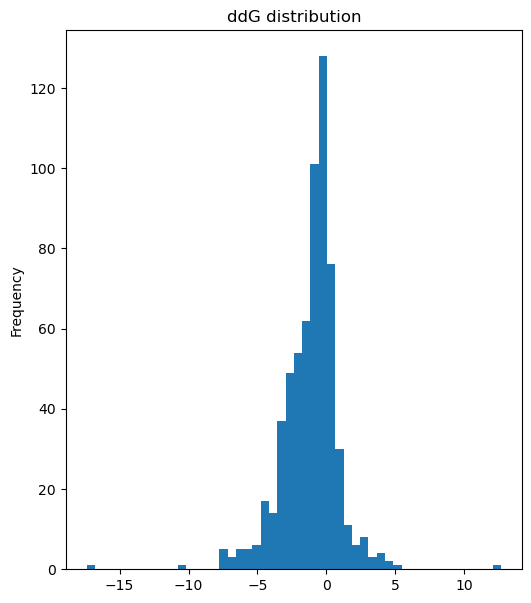

In [7]:
plot_hist(df)

In [8]:
def load_S3568():
    df = pd.read_csv(f'{DATASETS_PATH}/S3568_training.txt', sep="\t")
    df = df.rename(columns={
        'CHAIN': 'chain',
        'PDBPOSITION': 'pdb_position',
        # 'SEQPOSITION': 'seq_position', # seq positions are invalid
        'MUTANT': 'mutant',
        'PH': 'pH',
        'DDG': 'ddG',
        'WDTYPE': 'wildtype',
    })
    df['source'] = 'iStable2.0 - s3568'
    df.PDB = df.PDB.str.lower()

    return df.filter(COLUMNS)

df = load_S3568()
df


,PDB,chain,wildtype,pdb_position,mutant,ddG,pH,source
0,1e65,A,V,5,A,0.00,7.0,iStable2.0 - s3568
1,1e65,A,I,7,A,-3.11,7.0,iStable2.0 - s3568
2,1e65,A,I,7,S,-3.44,7.3,iStable2.0 - s3568
3,1e65,A,I,20,A,-1.56,7.0,iStable2.0 - s3568
4,1e65,A,I,20,T,-2.39,7.0,iStable2.0 - s3568
...,...,...,...,...,...,...,...,...
3563,5pti,A,G,36,D,-2.80,8.7,iStable2.0 - s3568
3564,5pti,A,G,36,S,-0.70,4.6,iStable2.0 - s3568
3565,5pti,A,G,37,A,-3.01,5.5,iStable2.0 - s3568
3566,5pti,A,G,37,D,-1.70,8.7,iStable2.0 - s3568


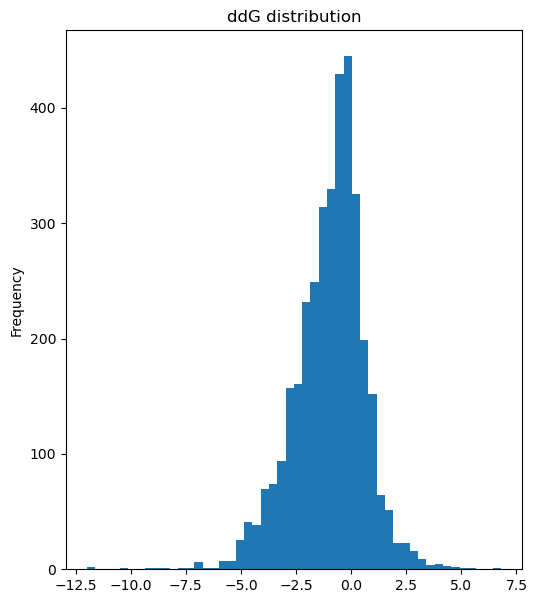

In [9]:
plot_hist(df)

## [ThermoMutDB](http://biosig.unimelb.edu.au/thermomutdb)

In [10]:
def load_thermomutdb():
    df = pd.DataFrame(json.load(open(f'{DATASETS_PATH}/thermomutdb.json', 'r'))).query('mutation_type == "Single"')
    df = df.rename(columns={
        'PDB_wild': 'PDB',
        'mutated_chain': 'chain',
        'ddg': 'ddG',
        'dtm': 'dT',
    })
    df['wildtype'] = df.mutation_code.str[0]
    df['mutant'] = df.mutation_code.str[-1]
    df['pdb_position'] = df.mutation_code.str.strip().str[1:-1]
    df = df[df.pdb_position.str.isdigit()]
    df.pdb_position = df.pdb_position.astype(int)
    df['source'] = 'ThermoMutDB'
    df.PDB = df.PDB.str.lower()

    return df.filter(COLUMNS + ['mutation_code'])

df = load_thermomutdb()
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,source,mutation_code
0,1wq5,A,E,49,M,4.60,NaN,ThermoMutDB,E49M
1,1wq5,A,E,49,Q,-2.50,NaN,ThermoMutDB,E49Q
2,2lzm,A,W,138,Y,-1.71,-6.3,ThermoMutDB,W138Y
5,1tup,A,C,242,S,-3.07,NaN,ThermoMutDB,C242S
6,1tup,A,F,134,L,-4.78,NaN,ThermoMutDB,F134L
...,...,...,...,...,...,...,...,...,...
13332,1a5e,A,L,78,G,NaN,0.9,ThermoMutDB,L78G
13333,1a5e,A,V,95,K,NaN,1.0,ThermoMutDB,V95K
13334,1a5e,A,W,15,D,NaN,2.2,ThermoMutDB,W15D
13335,1a5e,A,R,124,D,NaN,-0.4,ThermoMutDB,R124D


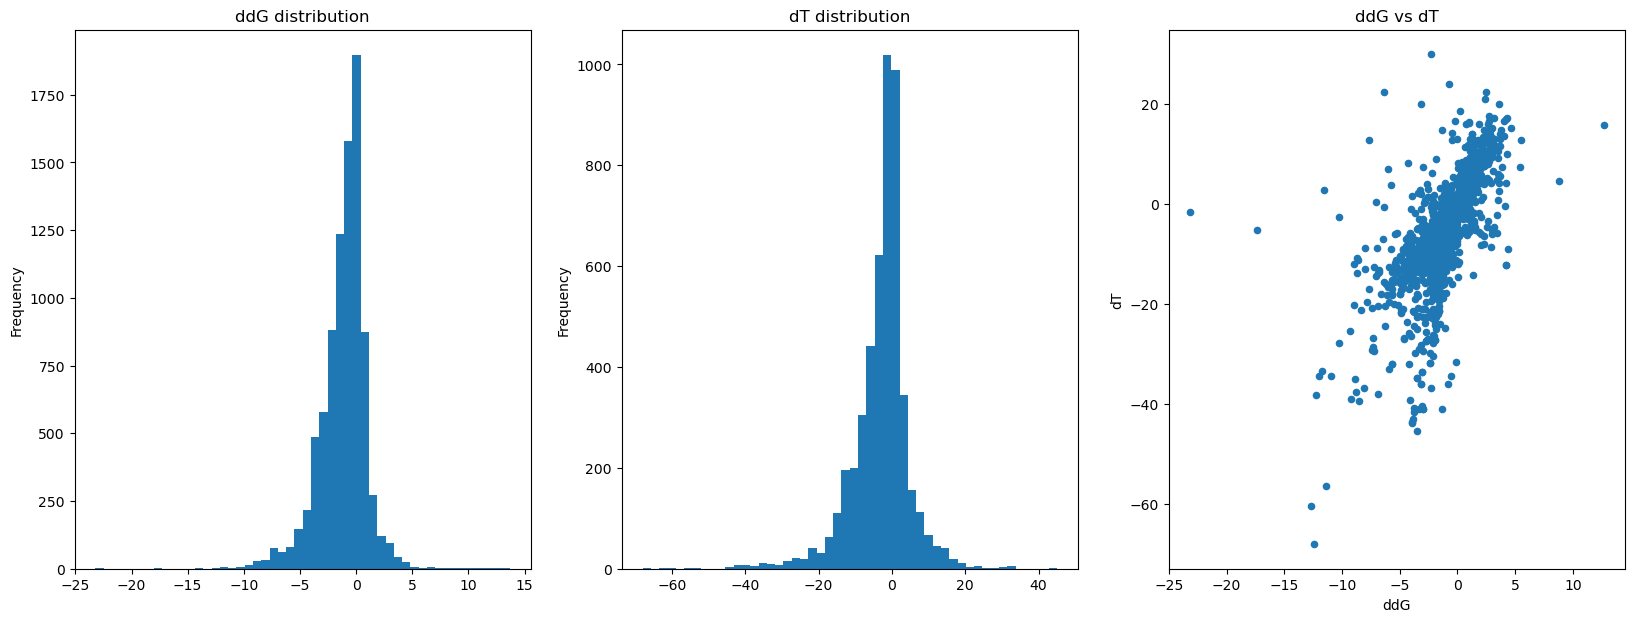

In [11]:
plot_hist(df)

## [xgboost-5000-mutations-200-pdb-files-lb-0-40](https://www.kaggle.com/code/cdeotte/xgboost-5000-mutations-200-pdb-files-lb-0-40)

In [12]:
def load_kaggle_mutations_dt():
    df = pd.read_csv(f'{DATASETS_PATH}/dt-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv').drop(columns=['PDB', 'sequence']).rename(
        columns={
            'WT': 'wildtype',
            'MUT': 'mutant',
            'position': 'pdb_position',
            'dTm': 'dT',
            'CIF': 'PDB'
        })
    df['chain'] = 'A'
    df['source'] = 'dt-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'
    return df.filter(COLUMNS)


df_kaggle = load_kaggle_mutations_dt()
df_kaggle

,PDB,chain,wildtype,pdb_position,mutant,dT,source
0,AF-P00644-F1,A,T,95,C,1.297838,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
1,AF-P00644-F1,A,T,95,C,0.097838,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
2,AF-P00644-F1,A,T,95,S,2.297838,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
3,AF-P00644-F1,A,T,95,S,3.697838,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
4,AF-P00644-F1,A,T,104,C,2.397838,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
...,...,...,...,...,...,...,...
1732,AF-P07998-F1,A,R,32,A,1.520000,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
1733,AF-P07998-F1,A,K,34,A,1.020000,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
1734,AF-P07998-F1,A,Q,37,E,-0.380000,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...
1735,AF-P07998-F1,A,S,45,N,-1.680000,dt-xgboost-5000-mutations-200-pdb-files-lb-0-4...


In [13]:
cifs = ' '.join([f'gs://public-datasets-deepmind-alphafold/{cif}-model_v3.cif' for cif in df_kaggle.PDB.unique() if
                 not os.path.exists(f'{DATASETS_PATH}/cifs/{cif}-model_v3.cif')])
cifs

''

In [14]:
# Need to copy from Google cloud
if len(cifs) > 0:
    !gsutil  -q -m  cp $cifs $DATASETS_PATH/cifs/ # data / cifs

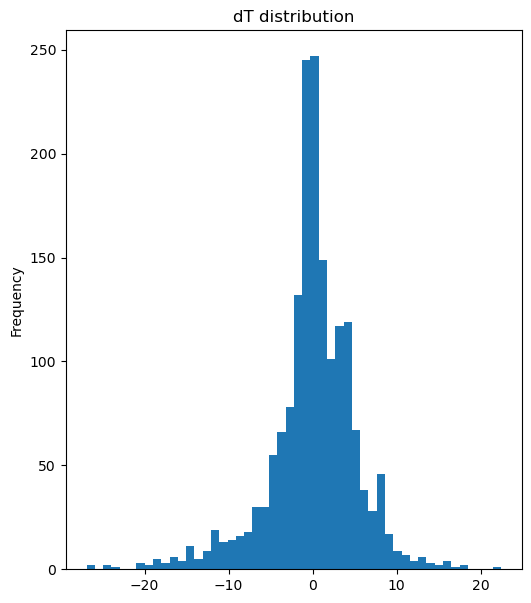

In [15]:
plot_hist(df_kaggle)

In [16]:
def load_kaggle_mutations_ddg():
    df = pd.read_csv(f'{DATASETS_PATH}/ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv').drop(columns=['sequence']).rename(
        columns={
            'mutation': 'mutant',
            'position': 'pdb_position',
        }).drop(columns=['Unnamed: 0'])
    df['chain'] = 'A'
    df['source'] = 'ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'
    df.PDB = df.PDB.str.lower()
    return df.filter(COLUMNS)


df_kaggle = load_kaggle_mutations_ddg()
df_kaggle

,PDB,chain,wildtype,pdb_position,mutant,ddG,source
0,1a5e,A,L,121,R,0.66,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
1,1a5e,A,L,37,S,0.71,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
2,1a5e,A,W,15,D,0.17,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
3,1a5e,A,D,74,N,-2.00,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
4,1a5e,A,P,81,L,0.00,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
...,...,...,...,...,...,...,...
3834,2lzm,A,W,126,R,-5.74,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
3835,2lzm,A,Y,25,G,-4.55,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
3836,2mpc,A,R,39,W,2.08,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...
3837,2mpc,A,A,86,T,-0.24,ddg-xgboost-5000-mutations-200-pdb-files-lb-0-...


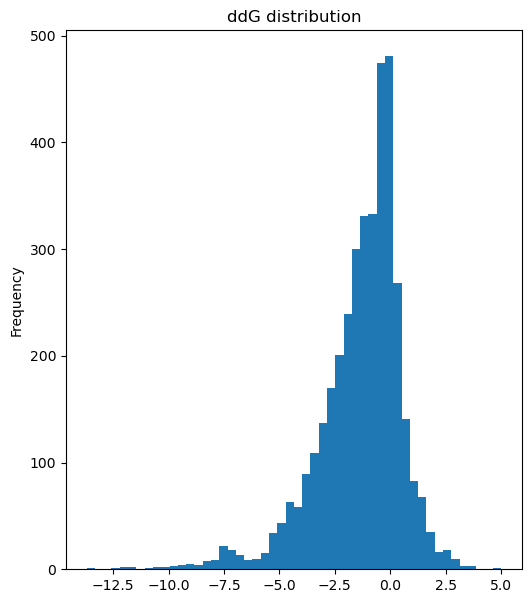

In [17]:
plot_hist(df_kaggle)

## [S1626](https://aip.scitation.org/doi/suppl/10.1063/1.4947493)

In [18]:
# ! pip install openpyxl

In [19]:
def load_pucci():
    """
    https://aip.scitation.org/doi/suppl/10.1063/1.4947493
    """
    df = pd.read_excel(f'{DATASETS_PATH}/pucci-proteins-appendixtable1.xlsx').drop(columns=['Unnamed: 0', 'N']).loc[1:]
    df = df.rename(
        columns={'PDBid': 'PDB', 'Chain': 'chain', 'RESN': 'pdb_position', 'RESwt': 'wildtype', 'RESmut': 'mutant',
                 'ΔTmexp': 'dT', 'Tmexp [wt]': 'wT', 'ΔΔGexp(T)': 'ddG'})
    df.mutant = df.mutant.str.capitalize().str.strip().map(Bio.SeqUtils.IUPACData.protein_letters_3to1)
    df.wildtype = df.wildtype.str.capitalize().str.strip().map(Bio.SeqUtils.IUPACData.protein_letters_3to1)
    df.PDB = df.PDB.str.lower()
    df.pH = df.pH.str.replace('[^-0-9.]', '', regex=True)
    df.ddG = df.ddG.str.replace('[^-0-9.]|^-$', '', regex=True)

    def to_float(v):
        try:
            return float(v)
        except:
            return None

    df.pH = df.pH.map(to_float)
    df.ddG = df.ddG.map(to_float)
    df.dT = df.dT.astype(float)
    df['source'] = 'pucci-proteins-appendixtable1.xlsx'
    return df.filter(COLUMNS)


df_pucci = load_pucci()
df_pucci

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,wT,pH,source
1,1aky,A,V,8.0,I,5.0,-1.5,47.6,7.5,pucci-proteins-appendixtable1.xlsx
2,1aky,A,Q,48.0,E,4.0,-1.3,47.6,7.7,pucci-proteins-appendixtable1.xlsx
3,1aky,A,T,77.0,H,9.0,-1.1,47.6,7.5,pucci-proteins-appendixtable1.xlsx
4,1aky,A,T,110.0,H,11.0,-4.8,47.6,7.6,pucci-proteins-appendixtable1.xlsx
5,1aky,A,N,169.0,D,9.0,-0.6,47.6,7.5,pucci-proteins-appendixtable1.xlsx
...,...,...,...,...,...,...,...,...,...,...
1622,5pti_m52l,A,K,15.0,S,1.2,-1.3,91.7,3.0,pucci-proteins-appendixtable1.xlsx
1623,5pti_m52l,A,K,15.0,T,-3.6,-1.1,91.7,3.0,pucci-proteins-appendixtable1.xlsx
1624,5pti_m52l,A,K,15.0,V,4.7,-6.3,91.7,3.0,pucci-proteins-appendixtable1.xlsx
1625,5pti_m52l,A,K,15.0,W,8.5,-7.5,91.7,2.5,pucci-proteins-appendixtable1.xlsx


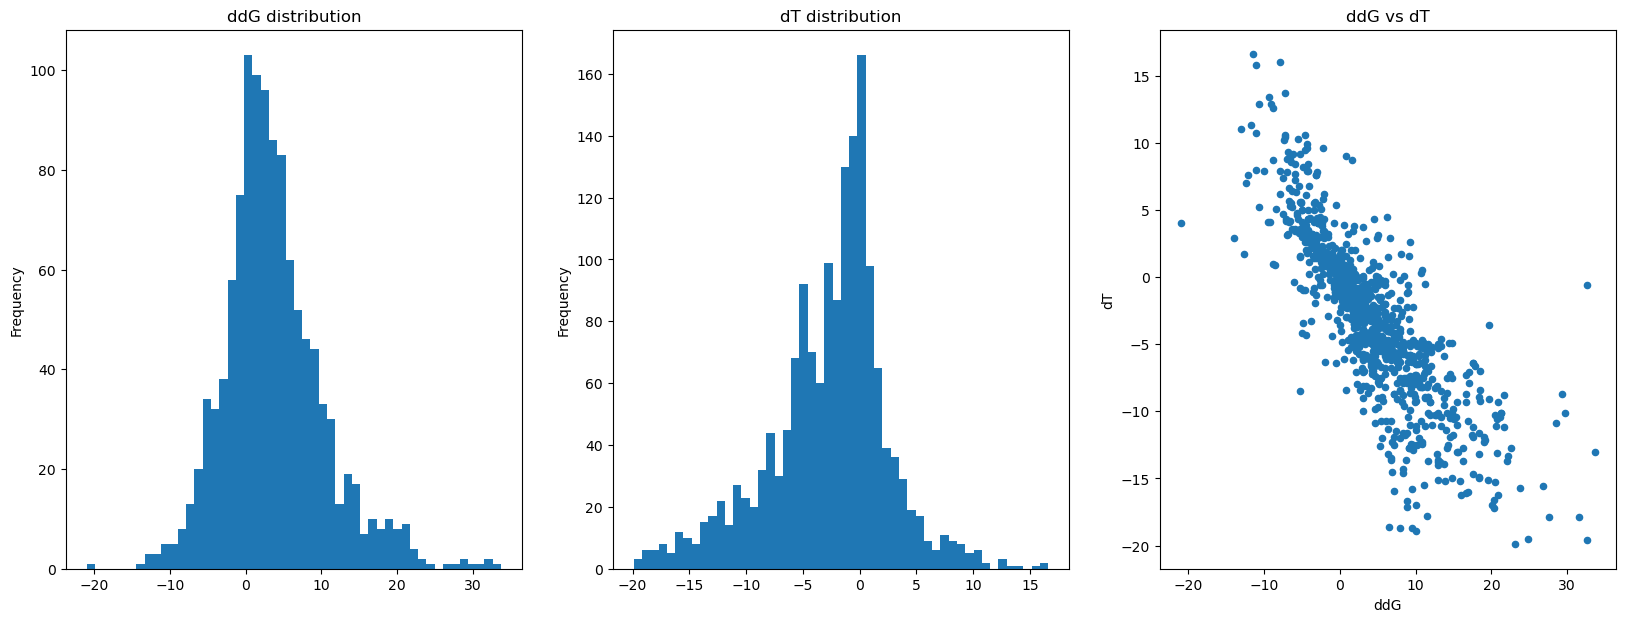

In [20]:
plot_hist(df_pucci)

## [S140](http://marid.bioc.cam.ac.uk/sdm2/data)

In [21]:
def load_s140():
    df = pd.read_csv(f'{DATASETS_PATH}/dataset_S140.csv').rename(columns={
        'Wildtype': 'PDB', ' ∆∆G (kcal/mol)': 'ddG', ' Mutation': 'mutation'
    })[['PDB', 'mutation', 'ddG']]
    df['wildtype'] = df['mutation'].str[1]
    df['chain'] = df.PDB.str[-1]
    df.PDB = df.PDB.str[:-1].str.lower()
    df['mutant'] = df['mutation'].str[-1]
    df['pdb_position'] = df['mutation'].str.slice(2, -1).astype(int)
    df['source'] = 'dataset_S140.csv'
    return df.filter(COLUMNS)


df = load_s140()
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,source
0,1bni,A,S,91,A,-1.38,dataset_S140.csv
1,1bni,A,Y,78,F,-1.40,dataset_S140.csv
2,1bni,A,T,26,A,-2.11,dataset_S140.csv
3,1bni,A,F,7,L,-4.60,dataset_S140.csv
4,1bni,A,L,14,A,-4.30,dataset_S140.csv
...,...,...,...,...,...,...,...
135,2rn2,A,D,70,N,-0.30,dataset_S140.csv
136,4lyz,A,S,91,T,0.99,dataset_S140.csv
137,4lyz,A,I,55,V,-0.91,dataset_S140.csv
138,4lyz,A,T,40,S,-0.27,dataset_S140.csv


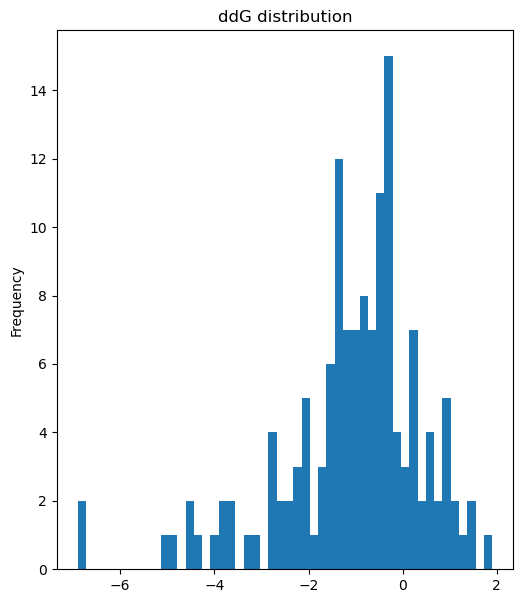

In [22]:
plot_hist(df)

## [S2648](http://marid.bioc.cam.ac.uk/sdm2/data)

In [23]:
def load_s350_s2648(fname):
    df = pd.read_csv(fname).rename(columns={
        'PH': 'pH',
        'PDB_CHAIN': 'PDB',
        'WILD_RES': 'wildtype',
        'MUTANT_RES': 'mutant',
        'EXP_DDG': 'ddG',
        'POSITION': 'pdb_position'
    })
    df['chain'] = df.PDB.str[-1]
    df.PDB = df.PDB.str[:-1].str.lower()
    df['source'] = os.path.basename(fname)
    return df.filter(COLUMNS)


df = load_s350_s2648(f'{DATASETS_PATH}/dataset_S350.csv')
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,pH,source
0,1aj3,A,H,10,A,0.50,7.0,dataset_S350.csv
1,1aj3,A,I,23,A,-3.60,7.0,dataset_S350.csv
2,1aj3,A,E,25,A,0.10,7.0,dataset_S350.csv
3,1aj3,A,K,26,A,-0.00,7.0,dataset_S350.csv
4,1aj3,A,V,30,A,-0.20,7.0,dataset_S350.csv
...,...,...,...,...,...,...,...,...
345,5dfr,A,G,121,H,-0.56,7.0,dataset_S350.csv
346,5dfr,A,I,155,T,-2.53,7.8,dataset_S350.csv
347,5pti,A,A,16,T,-1.70,8.7,dataset_S350.csv
348,5pti,A,A,16,V,-1.30,8.7,dataset_S350.csv


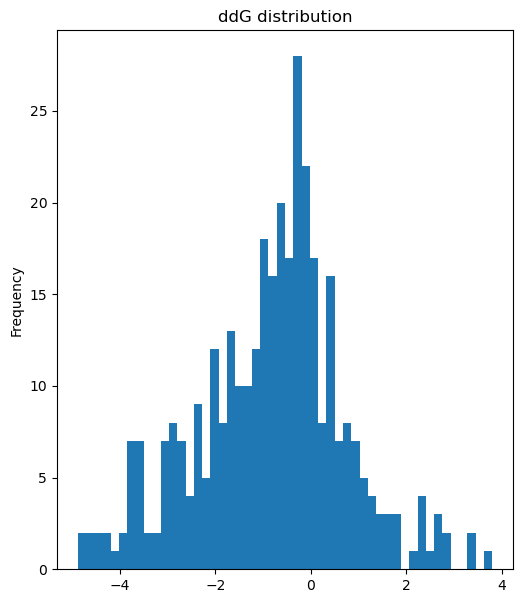

In [24]:
plot_hist(df)

In [25]:
df = load_s350_s2648(f'{DATASETS_PATH}/dataset_S2648.csv')
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,pH,source
0,1a43,A,G,156,A,-2.40,7.3,dataset_S2648.csv
1,1a43,A,E,159,D,-4.55,7.3,dataset_S2648.csv
2,1a43,A,R,167,A,-4.55,7.3,dataset_S2648.csv
3,1a43,A,W,184,A,-0.70,7.3,dataset_S2648.csv
4,1a43,A,C,218,S,-3.70,7.3,dataset_S2648.csv
...,...,...,...,...,...,...,...,...
2643,5pti,A,G,36,D,-2.80,8.7,dataset_S2648.csv
2644,5pti,A,G,36,S,-0.70,4.6,dataset_S2648.csv
2645,5pti,A,G,37,A,-3.01,5.5,dataset_S2648.csv
2646,5pti,A,G,37,D,-1.70,8.7,dataset_S2648.csv


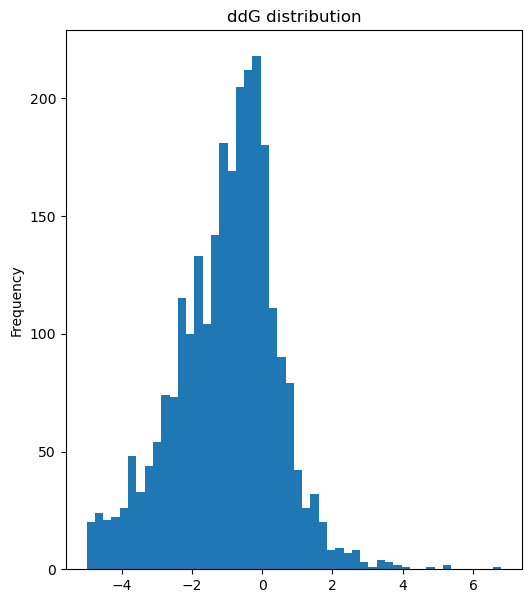

In [26]:
plot_hist(df)

## [Q3214, Q1744](https://github.com/gersteinlab/ThermoNet/tree/master/data/datasets)

In [27]:
def load_Q1744_Q3214(fname):
    df = pd.read_csv(fname).rename(columns={
        'pdb_id': 'PDB',
        'wild_type': 'wildtype',
        'ddg': 'ddG',
        'position': 'pdb_position'
    })
    df['chain'] = df.PDB.str[-1]
    df.PDB = df.PDB.str[:-1].str.lower()
    df['source'] = os.path.basename(fname)
    df.ddG = -df.ddG
    return df.filter(COLUMNS)

In [28]:
df = load_Q1744_Q3214(f'{DATASETS_PATH}/Q1744_direct.csv')
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,source
0,1otr,B,E,34,A,0.07,Q1744_direct.csv
1,1rtb,A,A,4,S,-0.47,Q1744_direct.csv
2,1thq,A,M,157,A,-0.77,Q1744_direct.csv
3,1tpk,A,V,65,I,0.30,Q1744_direct.csv
4,1rtb,A,Y,97,A,-12.00,Q1744_direct.csv
...,...,...,...,...,...,...,...
1739,1ftg,A,E,61,K,0.13,Q1744_direct.csv
1740,1cyo,A,V,45,E,-2.37,Q1744_direct.csv
1741,1ftg,A,V,83,I,0.05,Q1744_direct.csv
1742,1ycc,A,G,6,A,-3.50,Q1744_direct.csv


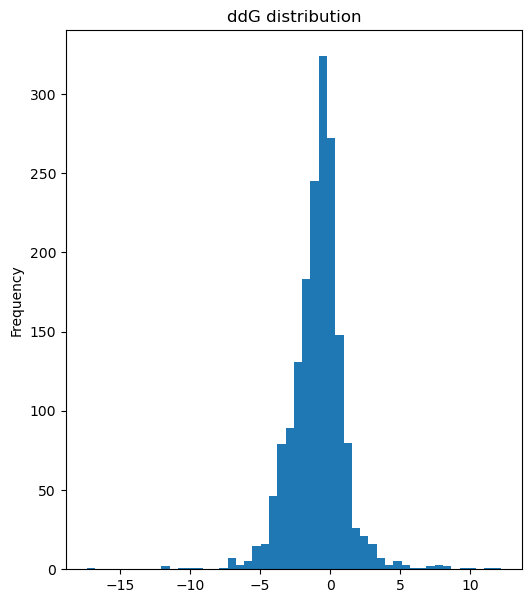

In [29]:
plot_hist(df)

In [30]:
df = load_Q1744_Q3214(f'{DATASETS_PATH}/Q3214_direct.csv')

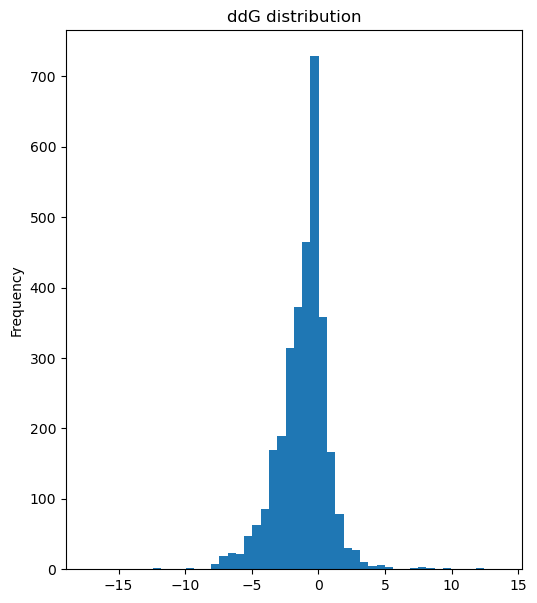

In [31]:
plot_hist(df)

## [Q3421](https://github.com/gersteinlab/ThermoNet/tree/master/data/datasets)

In [32]:
def load_Q3421():
    df = pd.read_csv(f'{DATASETS_PATH}/Q3421.txt',
                     delimiter="\s+").iloc[1:].reset_index(drop=True).rename(columns={
        'PDB_ID': 'PDB',
        'Chain': 'chain',
        'Pos(PDB)': 'pdb_position',
        'Wildtype': 'wildtype',
    })
    df['source'] = 'Q3421.txt'
    df.PDB = df.PDB.str.lower()
    df.ddG = df.ddG.astype(float)
    return df.filter(COLUMNS)


df = load_Q3421()
df

,PDB,chain,wildtype,pdb_position,mutant,ddG,pH,source
0,1a23,A,C,33,S,-1.10,7.5,Q3421.txt
1,1a23,A,C,30,S,-1.80,7.5,Q3421.txt
2,1a23,A,H,32,L,4.95,7,Q3421.txt
3,1a23,A,H,32,Y,4.63,7,Q3421.txt
4,1a23,A,H,32,S,4.40,7,Q3421.txt
...,...,...,...,...,...,...,...,...
3416,5cro,A,Y,26,Q,1.40,7,Q3421.txt
3417,5cro,A,Y,26,L,1.10,7,Q3421.txt
3418,5cro,A,Y,26,V,0.90,7,Q3421.txt
3419,5cro,A,Y,26,F,0.40,7,Q3421.txt


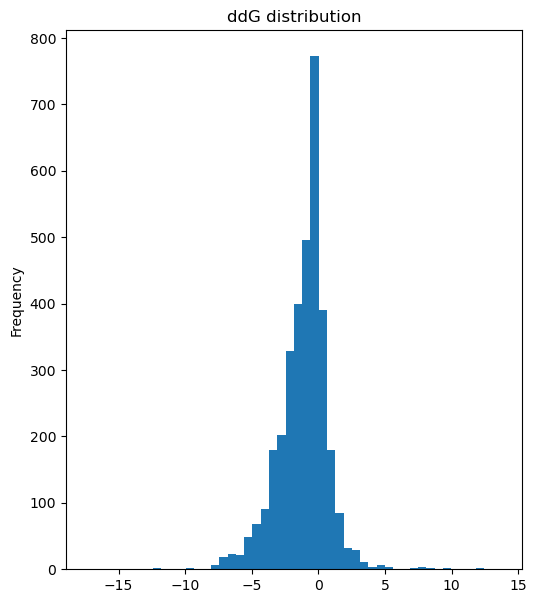

In [33]:
plot_hist(df)

## Combined dataset

In [34]:
df_combined = pd.concat([
    load_fireprot(),
    load_Q3421(),
    load_Q1744_Q3214(f'{DATASETS_PATH}/Q3214_direct.csv'),
    load_Q1744_Q3214(f'{DATASETS_PATH}/Q1744_direct.csv'),
    load_s350_s2648(f'{DATASETS_PATH}/dataset_S2648.csv'),
    load_s350_s2648(f'{DATASETS_PATH}/dataset_S350.csv'),
    load_s140(),
    load_pucci(),
    load_kaggle_mutations_dt(),
    load_kaggle_mutations_ddg(),  # a lot of inconsistencies between mutation positions and pdb files.
    load_thermomutdb(),
    load_S3568(),
    load_s630()
], axis=0).astype({'pdb_position': float, 'wT': float, 'pH': float}).filter(COLUMNS).reset_index(drop=True)
df_combined

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (23,24,25,26,29) have mixed types.Specify dtype option on import or set low_memory=False.
  
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,sequence,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,wT,pH,source
0,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,V,245.0,L,NaN,2.1,NaN,NaN,FireProtDB
1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,L,95.0,V,NaN,-0.4,NaN,NaN,FireProtDB
2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,C,176.0,F,NaN,5.2,NaN,NaN,FireProtDB
3,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,G,171.0,Q,NaN,3.1,NaN,NaN,FireProtDB
4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,T,148.0,L,NaN,1.1,NaN,NaN,FireProtDB
...,...,...,...,...,...,...,...,...,...,...,...
50080,NaN,3mbp,A,P,159.0,A,-1.8,NaN,NaN,7.4,iStable2.0 - s630
50081,NaN,3mbp,A,P,159.0,S,-2.1,NaN,NaN,7.4,iStable2.0 - s630
50082,NaN,3mbp,A,A,276.0,G,-1.5,NaN,NaN,7.6,iStable2.0 - s630
50083,NaN,3mbp,A,Y,283.0,D,-3.2,NaN,NaN,7.6,iStable2.0 - s630


In [35]:
df_combined['PDB_chain'] = df_combined.PDB + df_combined.chain.astype(str)

## Rescale Pucci dataset

In [36]:
def pucci(df):
    if len(df[df.source == 'pucci-proteins-appendixtable1.xlsx']) > 0 and len(
            df[df.source != 'pucci-proteins-appendixtable1.xlsx']) > 0:
        return pd.Series({'nonpucci': (df[df.source != 'pucci-proteins-appendixtable1.xlsx']).ddG.mean(),
                          'pucci': (df[df.source == 'pucci-proteins-appendixtable1.xlsx']).ddG.mean()})
    return None


df = df_combined.groupby(['PDB_chain', 'pdb_position', 'mutant']).apply(lambda df: pucci(df)).dropna().reset_index(drop=True)

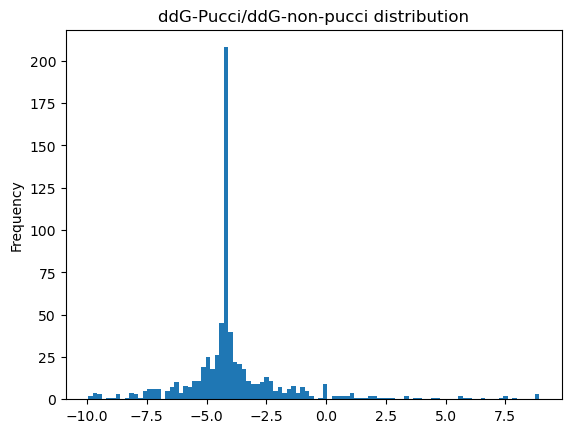

In [37]:
pucci_ratio = (df.pucci / df.nonpucci).replace([np.inf, -np.inf], None).dropna()
pucci_ratio = pucci_ratio[(pucci_ratio < 10) & (-10 < pucci_ratio)]
ax = pucci_ratio.plot.hist(bins=100, title='ddG-Pucci/ddG-non-pucci distribution')

In [38]:
PUCCI_K = (df.pucci / df.nonpucci).replace([np.inf, -np.inf], None).median()
PUCCI_K

-4.186991869918699

<AxesSubplot:xlabel='pucci', ylabel='nonpucci'>

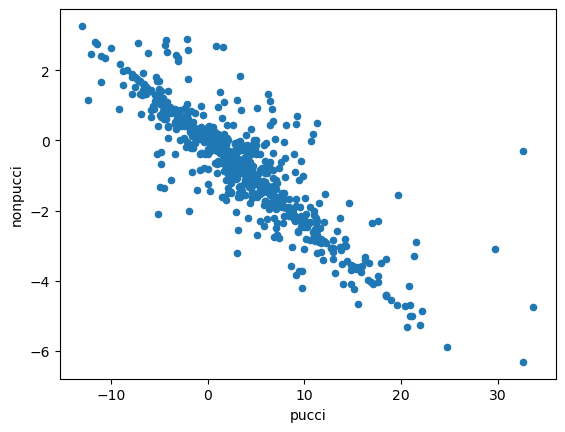

In [39]:
df.plot.scatter(x='pucci', y='nonpucci')

In [40]:
df_combined.loc[df_combined.source == 'pucci-proteins-appendixtable1.xlsx', 'ddG'] = df_combined.ddG / PUCCI_K

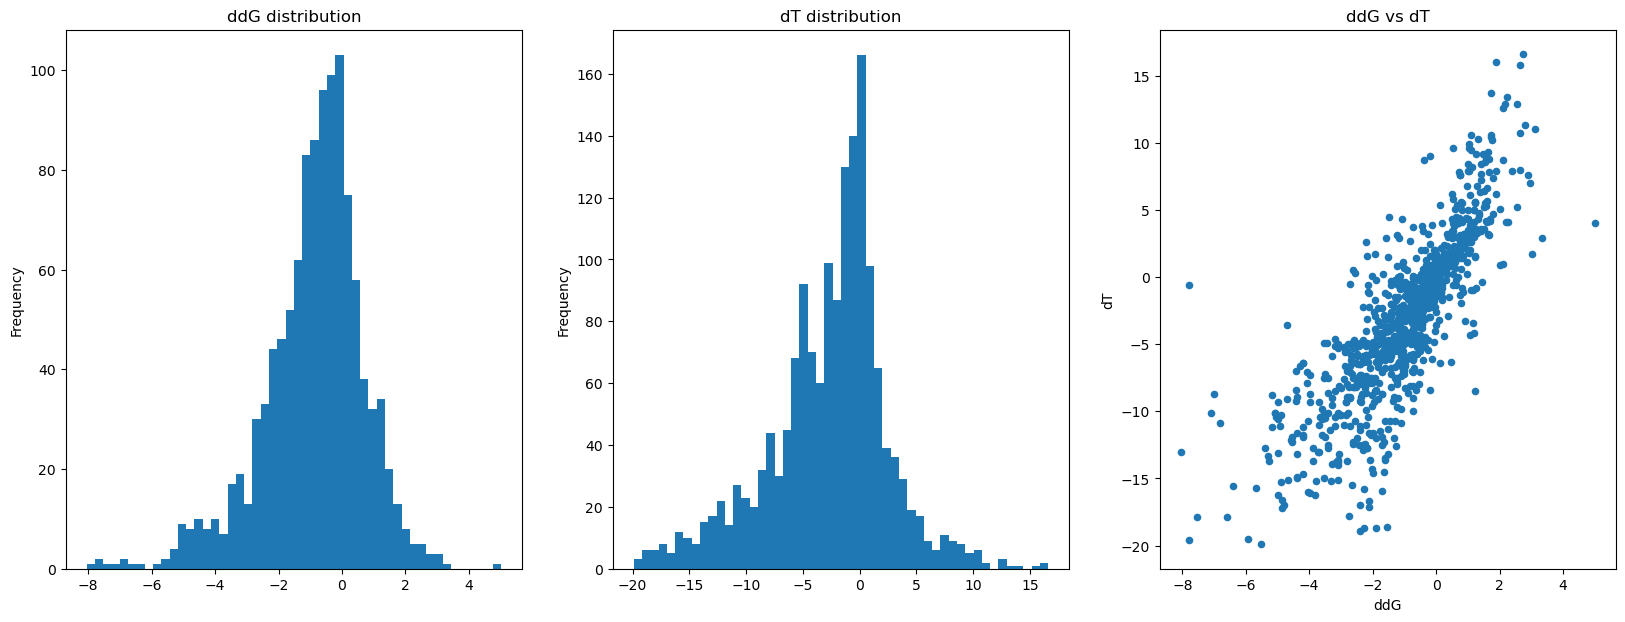

In [41]:
plot_hist(df_combined[df_combined.source == 'pucci-proteins-appendixtable1.xlsx'])

## Insights

In [42]:
df_combined.groupby('source').apply(lambda df: (df.ddG / df.dT).median())

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/xux/miniconda3/envs/prot-gen-env/l

source
FireProtDB                                              0.144000
Q1744_direct.csv                                             NaN
Q3214_direct.csv                                             NaN
Q3421.txt                                                    NaN
ThermoMutDB                                             0.261905
dataset_S140.csv                                             NaN
dataset_S2648.csv                                            NaN
dataset_S350.csv                                             NaN
ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv         NaN
dt-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv          NaN
iStable2.0 - s3568                                           NaN
iStable2.0 - s630                                            NaN
pucci-proteins-appendixtable1.xlsx                      0.282323
dtype: float64

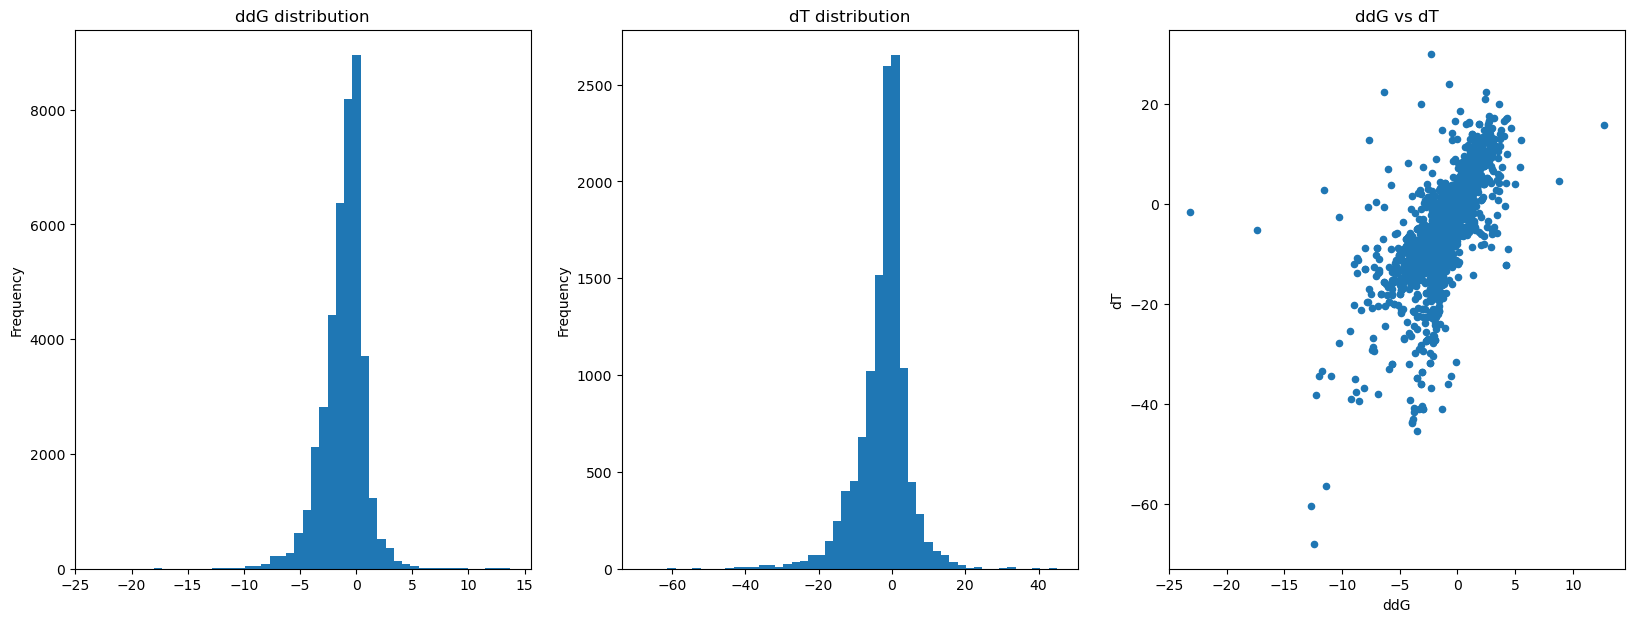

In [43]:
plot_hist(df_combined)

# Download wild-type structures

## Download AlphaFold2 structures

1. Produce the query to retrieve AlphaFold2 IDs by checksums of sequences
2. Run the resulting query in [BigQuery](https://console.cloud.google.com/bigquery?sq=264715149975:fb373d507b5645f3a7543f1e19315807)

In [44]:
# !pip install crc64iso
from crc64iso import crc64iso

In [45]:
def gen_af2_bigquery(df):
    checksums = "'" + "','".join(df.sequenceChecksum.dropna().unique()) + "'"
    return f"""
    SELECT
      sequenceChecksum,
      min(entryID) af2id
    FROM bigquery-public-data.deepmind_alphafold.metadata
    WHERE sequenceChecksum in ({checksums})
    GROUP BY sequenceChecksum
    """

In [46]:
df_combined['sequenceChecksum'] = df_combined.sequence.apply(lambda s: crc64iso.crc64(s) if type(s) is str else None)

sql = gen_af2_bigquery(df_combined)
print(sql)  # Need to run this query on Google Cloud BigQuery!  Query sequenceChecksum instead of pure sequence for fast query!


    SELECT
      sequenceChecksum,
      min(entryID) af2id
    FROM bigquery-public-data.deepmind_alphafold.metadata
    WHERE sequenceChecksum in ('190E6B9944E5DBEF','EAE98552A39D5E19','6EEE011B157DBAE1','4CA30BC483F87395','33ED493B8B5B0386','71042E4725BB31A0','ABBA31F903C3EA02','5CE1C12AC00D6CD3','A0759060C8F9E6CA','628F44507C21EF1F','9E76B3FFD3E09C93','DAB3C66E024F0E39','7F55D246CA4454F7','FE6D624ADD11939A','1FA4651BE5BF1393','566AF6681DFE94FE','BB678943BB18934B','6A03CDCD7F5F8562','D03BD4F657641FBA','A4C1B3C1777ADE47','FC14BAD02AACB652','1B6009120B945F14','3C3668B356A1CFD9','8FE2F3D1A9F89815','8770E93571C53531','AD5C149FD8106131','4D34653E7E026CB3','B8A70E027461188F','2987DDE85B2470B4','E19CEB474EB92B93','9D389A0EDD8DE692','3FCD43C56DB01E83','25243E5ED1D2773B','B8EF81EEB2F94CBE','9BF73C3673C6FD66','2FAD178DDC248CF0','42B6669F9B0D7FBA','BB917C84000A80EE','F409BF1A931581B5','8ECFD276BEB2678A','AD5558AA28E855D7','81E85743FF579468','02D568CC8FC81CF1','4785A4915479ED97','0A1986BD29CF6

In [47]:
def download_cif(fname):
    af2id = pd.read_csv(fname).af2id
    files = af2id.apply(lambda id: f'gs://public-datasets-deepmind-alphafold/{id}-model_v3.cif' if not os.path.exists(f'{DATASETS_PATH}/cifs/{id}-model_v3.cif') else None).dropna()
    files = ' '.join(files)
    # print(type(files))
    if len(files) > 0:
       #!cat $files | gsutil -m cp -I $DATASETS_PATH/cifs  # 
       !gsutil -m -q cp $files $DATASETS_PATH/cifs #  !gsutil  -q -m  cp 

In [48]:
!gsutil -m cp gs://public-datasets-deepmind-alphafold/AF-P06213-F1-model_v3.cif gs://public-datasets-deepmind-alphafold/AF-P00644-F1-model_v3.cif $DATASETS_PATH/cifs

Copying gs://public-datasets-deepmind-alphafold/AF-P06213-F1-model_v3.cif...
Copying gs://public-datasets-deepmind-alphafold/AF-P00644-F1-model_v3.cif...
- [2/2 files][315.1 KiB/315.1 KiB] 100% Done                                    
Operation completed over 2 objects/315.1 KiB.                                    


In [49]:
AF2_FILE = f'{DATASETS_PATH}/af2_result.csv'  # this is your BigQuery result

if os.path.exists(AF2_FILE):
    download_cif(AF2_FILE)

## Download PDB structures

In [53]:
def download_pdbs(df):
    existing_pdbs = set([os.path.basename(f)[:4] for f in glob.glob(f'{DATASETS_PATH}/pdbs/*.pdb')])
    to_download = set(df[df.PDB.str.len() == 4].PDB.unique()) - existing_pdbs
    with tqdm(to_download) as prog:
        for pdb in prog:
            prog.set_description(f'Downloading {pdb}')
            fname = f'{DATASETS_PATH}/pdbs/{pdb}.pdb'
            url = f'https://files.rcsb.org/download/{pdb}.pdb'
            v = requests.get(url)
            if v.status_code != 200:
                print(url, 'status code', v.status_code)
                continue
            with open(fname, 'w+') as f:
                f.write(v.content.decode('utf-8'))


download_pdbs(df_combined)

0it [00:00, ?it/s]

In [54]:
!ls $DATASETS_PATH/pdbs | wc -l

583


# Obtain wild-type and varaint PDBs

## Split CIFs, PDBs to chains

In [55]:
def pdbs_to_chains():
    chain_seq = []

    # CIF
    import Bio.PDB as PDB
    parser = PDB.MMCIFParser()
    pdbio = PDBIO()
    for f in tqdm(glob.glob(f'{DATASETS_PATH}/cifs/*.cif'), 'CIF file chains'):
        id = '-'.join(os.path.basename(f).split('-')[:-1])
        structure = parser.get_structure(id, f)
        model = next(iter(structure.get_models()))
        for chain in model.get_chains():
            chain_name = f'{id}{chain.get_id()}'
            pdb = f'{DATASETS_PATH}/chains/{chain_name}.pdb'
            chain_seq.append({
                'PDB_chain': chain_name,
                'sequence': seq1(''.join(residue.resname for residue in chain)),
                'pdb_ids': tuple([r.get_id()[1] for r in chain]),
                # 'file': pdb
            })
            if not os.path.exists(pdb):
                pdbio.set_structure(chain)
                pdbio.save(f'{DATASETS_PATH}/chains/{chain_name}.pdb')

    # PDBs
    parser = PDBParser()
    io = PDBIO()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with tqdm(glob.glob(f'{DATASETS_PATH}/pdbs/*.pdb'), desc='PDBs') as prog:
            for pdb in prog:
                id = os.path.basename(pdb)[:4]
                prog.set_description(id)
                structure = parser.get_structure(id, pdb)

                # validate
                models = list(structure.get_models())
                for i in range(len(models) - 1):
                    s1 = seq1(''.join(residue.resname for residue in models[i].get_residues()))
                    s2 = seq1(''.join(residue.resname for residue in models[i + 1].get_residues()))
                    assert s1 == s2, "Invalid models"

                pdb_chains = structure.get_chains()

                for chain in pdb_chains:
                    chain_name = f'{structure.get_id()}{chain.get_id()}'
                    chain_seq.append({
                        'PDB_chain': chain_name,
                        'sequence': seq1(''.join(residue.resname for residue in chain)),
                        'pdb_ids': tuple([r.get_id()[1] for r in chain]),
                        # 'file': pdb
                    })
                    if not os.path.exists(f'{DATASETS_PATH}/chains/{chain_name}.pdb'):
                        io.set_structure(chain)
                        io.save(f'{DATASETS_PATH}/chains/{chain_name}.pdb')

    return pd.DataFrame(chain_seq).drop_duplicates()


df_chains = pdbs_to_chains()

CIF file chains:   0%|          | 0/259 [00:00<?, ?it/s]

PDBs:   0%|          | 0/583 [00:00<?, ?it/s]

In [57]:
df_chains

,PDB_chain,sequence,pdb_ids
0,AF-A0A0E0TCY0-F1A,MNKTELINAVAETSGLSKKDATKAVDAVFDSITEALRKGDKVQLIG...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,AF-P00648-F1A,MMKMEGIALKKRLSWISVCLLVLVSAAGMLFSTAAKTETSSHKAHT...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,AF-A0A029HGX2-F1A,MSGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLD...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,AF-A0A2W0F5X5-F1A,MNQSVSSLPEKDIQYQLHPYTNARLHQELGPLIIERGEGIYVYDDQ...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,AF-A0A0E0Y2P4-F1A,MKKTAIAIAVALAGFATVAQAAPKDNTWYTGAKLGWSQYHDTGFIN...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...
3309,2zajA,GSSGSSGLDSELELPAGWEKIEDPVYGIYYVDHINRKTQYENPSGPSSG,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3329,1w4hA,QNNDALSPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKA,"(126, 127, 128, 129, 130, 131, 132, 133, 134, ..."
3349,2nvhA,APVRSLNCTLRDSQQKSLVMSGPYELKALHLQGQDMEQQVVFSMSF...,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3350,1bahA,XFTNVSCTTSKEXWSVCQRLHNTSRGKCMNKKXRCYS,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


## Deduplicate mutations

Join with PDBs by either PDB is or by sequence. 

In [58]:
df_ds_pdb = pd.merge(df_combined, df_chains, on='PDB_chain', how='inner', suffixes=('', '_PDB'))
assert len(df_ds_pdb[~df_ds_pdb.sequence.isna() & ~df_ds_pdb.sequence_PDB.isna() & (df_ds_pdb.sequence != df_ds_pdb.sequence_PDB)]) == 0, 'Invalid pdb sequences'
df_ds_pdb.sequence = df_ds_pdb[['sequence', 'sequence_PDB']].bfill(axis=1).iloc[:, 0]
df_ds_pdb.drop(columns=['sequence_PDB'], inplace=True)
df_ds_pdb

,sequence,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,wT,pH,source,PDB_chain,sequenceChecksum,pdb_ids
0,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,C,33.0,S,-1.10,NaN,NaN,7.5,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,C,30.0,S,-1.80,NaN,NaN,7.5,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32.0,L,4.95,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32.0,Y,4.63,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32.0,S,4.40,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33596,GTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPF...,1cdc,B,L,50.0,V,-0.37,NaN,NaN,7.0,iStable2.0 - s630,1cdcB,None,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
33597,GTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPF...,1cdc,B,I,57.0,V,0.43,NaN,NaN,7.0,iStable2.0 - s630,1cdcB,None,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
33598,GTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPF...,1cdc,B,V,78.0,A,3.01,NaN,NaN,7.0,iStable2.0 - s630,1cdcB,None,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
33599,GTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPF...,1cdc,B,L,89.0,V,0.14,NaN,NaN,7.0,iStable2.0 - s630,1cdcB,None,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


In [59]:
df_ds_seq = pd.merge(df_combined.drop(columns=['PDB_chain']), df_chains, on='sequence', how='inner').reset_index(drop=True)
df_ds_seq

,sequence,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,wT,pH,source,sequenceChecksum,PDB_chain,pdb_ids
0,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,V,245.0,L,NaN,2.1,NaN,NaN,FireProtDB,190E6B9944E5DBEF,AF-P59336-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,L,95.0,V,NaN,-0.4,NaN,NaN,FireProtDB,190E6B9944E5DBEF,AF-P59336-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,C,176.0,F,NaN,5.2,NaN,NaN,FireProtDB,190E6B9944E5DBEF,AF-P59336-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,G,171.0,Q,NaN,3.1,NaN,NaN,FireProtDB,190E6B9944E5DBEF,AF-P59336-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,NaN,A,T,148.0,L,NaN,1.1,NaN,NaN,FireProtDB,190E6B9944E5DBEF,AF-P59336-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20084,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...,NaN,X,M,1775.0,R,-4.2,NaN,NaN,9.0,FireProtDB,89C6D83FF56312AF,AF-P38398-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
20085,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...,NaN,X,V,1833.0,M,-1.7,NaN,NaN,9.0,FireProtDB,89C6D83FF56312AF,AF-P38398-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
20086,MISGILASPGIAFGKALLLKEDEIVIDRKKISADQVDQEVERFLSG...,NaN,A,H,189.0,A,-0.9,NaN,NaN,7.5,FireProtDB,4278F0838855E950,AF-A0A037YGN3-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
20087,MISGILASPGIAFGKALLLKEDEIVIDRKKISADQVDQEVERFLSG...,NaN,A,H,189.0,E,-1.3,NaN,NaN,7.5,FireProtDB,4278F0838855E950,AF-A0A037YGN3-F1A,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [60]:
df_ds = pd.concat([df_ds_pdb, df_ds_seq], axis=0)

In [61]:
def position_error_stats(df):
    def valid_pdb(r):
        if np.isnan(r.pdb_position):
            return True
        if r.pdb_position in r.pdb_ids:
            idx = r.pdb_ids.index(r.pdb_position)
            if idx < len(r.sequence):
                if r.sequence[idx] == r.wildtype:
                    return True
        return False

    def valid_seq(r):
        if np.isnan(r.seq_position):
            return True
        if r.seq_position < len(r.sequence):
            if r.sequence[int(r.seq_position)] == r.wildtype:
                return True
        return False

    return pd.Series({
        'valid_pdb_position': df.apply(valid_pdb, axis=1).mean(),
        'pdb_position_count': (~df.pdb_position.isna()).sum(),

        # 'valid_seq_position': df.apply(valid_seq, axis=1).mean(),
        # 'seq_position_count': (~df.seq_position.isna()).sum(),
        'total_count': len(df),
    })


df_ds.groupby('source').apply(position_error_stats)

,valid_pdb_position,pdb_position_count,total_count
source,,,
FireProtDB,0.999602,20089.0,20089.0
Q1744_direct.csv,1.000000,1744.0,1744.0
Q3214_direct.csv,1.000000,3214.0,3214.0
Q3421.txt,1.000000,3421.0,3421.0
ThermoMutDB,0.891810,10842.0,10842.0
dataset_S140.csv,1.000000,140.0,140.0
dataset_S2648.csv,0.994335,2648.0,2648.0
dataset_S350.csv,1.000000,350.0,350.0
ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv,0.545115,3746.0,3746.0


In [62]:
def valid_pos(r):
    pos, pdb_ids = r.pdb_position, r.pdb_ids
    if pos not in pdb_ids:
        return False
    idx = pdb_ids.index(pos)
    if r.sequence[idx] != r.wildtype:
        return False
    return True

print('Invalid positions:', (~df_ds.apply(valid_pos, axis=1)).sum())

Invalid positions: 2903


In [63]:
df_ds = df_ds[df_ds.apply(valid_pos, axis=1)].reset_index(drop=True)

In [64]:
df_ds['seq_position'] = df_ds.apply(lambda r: r.pdb_ids.index(r.pdb_position) if r.pdb_position in r.pdb_ids else None, axis=1)
df_ds = df_ds.astype({'pdb_position': int, 'seq_position': int})

In [65]:
df_ds['mutant_PDB'] = df_ds.apply(lambda r: f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}_relaxed.pdb', axis=1)
df_ds['mutant_PDB'] = df_ds.apply(lambda r: r.mutant_PDB if os.path.exists(r.mutant_PDB) else None, axis=1)
df_ds['wildtype_PDB'] = df_ds.apply(lambda r: f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed.pdb', axis=1)
df_ds['wildtype_PDB'] = df_ds.apply(lambda r: r.wildtype_PDB if os.path.exists(r.wildtype_PDB) else None, axis=1)
df_ds

,sequence,PDB,chain,wildtype,pdb_position,mutant,ddG,dT,wT,pH,source,PDB_chain,sequenceChecksum,pdb_ids,seq_position,mutant_PDB,wildtype_PDB
0,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,C,33,S,-1.10,NaN,NaN,7.5,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",32,None,None
1,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,C,30,S,-1.80,NaN,NaN,7.5,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",29,None,None
2,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32,L,4.95,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",31,None,None
3,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32,Y,4.63,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",31,None,None
4,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,1a23,A,H,32,S,4.40,NaN,NaN,7.0,Q3421.txt,1a23A,None,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",31,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50782,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...,NaN,X,M,1775,R,-4.20,NaN,NaN,9.0,FireProtDB,AF-P38398-F1A,89C6D83FF56312AF,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1774,None,None
50783,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...,NaN,X,V,1833,M,-1.70,NaN,NaN,9.0,FireProtDB,AF-P38398-F1A,89C6D83FF56312AF,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1832,None,None
50784,MISGILASPGIAFGKALLLKEDEIVIDRKKISADQVDQEVERFLSG...,NaN,A,H,189,A,-0.90,NaN,NaN,7.5,FireProtDB,AF-A0A037YGN3-F1A,4278F0838855E950,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",188,None,None
50785,MISGILASPGIAFGKALLLKEDEIVIDRKKISADQVDQEVERFLSG...,NaN,A,H,189,E,-1.30,NaN,NaN,7.5,FireProtDB,AF-A0A037YGN3-F1A,4278F0838855E950,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",188,None,None


In [89]:
df_clean = df_ds.groupby(['sequence', 'wildtype', 'pdb_position', 'seq_position', 'mutant']).mean()
df_clean['source'] = df_ds.groupby(['sequence', 'wildtype', 'pdb_position', 'seq_position', 'mutant']).source.apply(lambda v: v.unique().tolist())
df_clean['PDB_chain'] = df_ds.sort_values('mutant_PDB').groupby(['sequence', 'wildtype', 'pdb_position', 'seq_position', 'mutant'], sort=False).PDB_chain.first()
# df_clean['mutant_PDB'] = df_ds.sort_values('mutant_PDB').groupby(['sequence', 'wildtype', 'pdb_position', 'seq_position', 'mutant'], sort=False).mutant_PDB.apply(lambda v: v.unique().tolist())
df_clean = df_clean.reset_index()
df_clean

,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain
0,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,473,471,C,0.000000,0.75,NaN,NaN,[ThermoMutDB],1ss8A
1,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,523,521,K,-1.100000,-3.75,NaN,NaN,[ThermoMutDB],1ss8A
2,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,K,4,2,E,-1.300000,-4.75,NaN,NaN,[ThermoMutDB],1ss8A
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,36,36,A,0.705833,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA
...,...,...,...,...,...,...,...,...,...,...,...
14651,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,323,210,D,-0.130000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14652,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14653,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-0.530000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14654,YVDKGYEPSKKRDIIAVFRVTPAEGYTIEQAAGAVAAESSTGTWTT...,E,63,51,S,NaN,-7.20,NaN,NaN,[ThermoMutDB],1gehA


## Relax wild-type PDBs

Run [Rosetta FastRelax](https://www.rosettacommons.org/docs/latest/scripting_documentation/RosettaScripts/Movers/movers_pages/FastRelaxMover). This produces more realistic shape of the protein by running multiple rounds of physics simulation. This is a prerequisite for ThermoNet models.
In this section we relax wildtype proteins

In [153]:
relaxed_chains = set(fn[:-12] for fn in os.listdir(f'{DATASETS_PATH}/relaxed_chains'))
non_relaxed_chains = list(set(df_clean.PDB_chain.unique()) - relaxed_chains)

print('Non relaxed chains', len(non_relaxed_chains)) #, non_relaxed_chains)

Non relaxed chains 731


In [91]:
# inline relaxation
N_JOBS = 60
RUN_FAST_RELAX= True

if RUN_FAST_RELAX:
    nrc = ' '.join([f'{f}.pdb' for f in non_relaxed_chains])
    print(f"ls {nrc} | parallel -j {N_JOBS} {ROSETTA_BIN}/relax.static.linuxgccrelease -in:file:s {{}}  -relax:constrain_relax_to_start_coords -out:suffix _relaxed -out:no_nstruct_label -relax:ramp_constraints false")
    # !cd {DATASETS_PATH}/chains/ && ls $nrc | parallel -j $N_JOBS $ROSETTA_BIN/relax.static.linuxgccrelease -in:file:s {{}}  -relax:constrain_relax_to_start_coords -out:suffix _relaxed -out:no_nstruct_label -relax:ramp_constraints false
    # mv chains/*_relaxed* relaxed_chains/

ls 1rx4A.pdb 1bahA.pdb | parallel -j 60 /home/xux/Desktop/Enzyme_stab/Enzyme_pred/rosetta/rosetta_bin_linux_2018.33.60351_bundle/main/source/bin/relax.static.linuxgccrelease -in:file:s {}  -relax:constrain_relax_to_start_coords -out:suffix _relaxed -out:no_nstruct_label -relax:ramp_constraints false


In [103]:
relaxed_chains = set(fn[:-12] for fn in os.listdir(f'{DATASETS_PATH}/relaxed_chains'))

# for chain in relaxed_chains:
#     ! mkdir {DATASETS_PATH}/relaxed_chains/{chain}
#     ! cp {DATASETS_PATH}/relaxed_chains/{chain}_relaxed.pdb {DATASETS_PATH}/relaxed_chains/{chain}

### Relax wild-type PDB Docker

This generates a Docker FastRelax job and imports results

In [ ]:
# if DOCKER:
#     for i, nrc in enumerate(np.array_split(non_relaxed_chains, 4)):
#         files = ' '.join([f'{c}.pdb' for c in nrc])
#         open(f'jobs/relax_pdb_{i}.Dockerfile', 'w+').write(f"""FROM alpine
# COPY rosetta/ /root/rosetta
# COPY data/chains /root/chains
# RUN apk add parallel
# WORKDIR /root/chains
# VOLUME /root/chains
# ENTRYPOINT ls {files} | parallel -j $N_JOBS /root/rosetta/bin/relax.static.linuxgccrelease -in:file:s {{}} -relax:constrain_relax_to_start_coords -out:suffix _relaxed -out:no_nstruct_label -relax:ramp_constraints false""")

#     # Import docker results
#     CHAINS_DIR = 'tmp/pdb_relaxed/chains'
#     import shutil

#     for c in tqdm(glob.glob(f'{CHAINS_DIR}/*_relaxed.pdb')):
#         id = os.path.basename(c)[:-12]
#         if not os.path.exists(f'data/relaxed_chains/{id}'):
#             print('create', id)
#             os.makedirs(f'data/relaxed_chains/{id}')
#             shutil.copy(c, f'data/relaxed_chains/{id}')
#         else:
# #             print('skipping', c)
#             pass

## Generate mutant PDBs


In [92]:
!mkdir -p {DATASETS_PATH}/tmp

In [157]:
df_clean[[os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed.pdb') 
          and not os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed_{r.wildtype}{r.pdb_position}{r.mutant}_relaxed.pdb') 
          for _, r in df_clean.iterrows()]] \
    [['PDB_chain', 'pdb_position', 'wildtype', 'mutant']].to_csv(f'{DATASETS_PATH}/tmp/mutations.txt', header=False, sep=' ', index=False)

In [158]:
!wc -l {DATASETS_PATH}/tmp/mutations.txt
!head {DATASETS_PATH}/tmp/mutations.txt

194 data/thermonet/tmp/mutations.txt
1znjB 25 F D
1znjB 25 F H
1znjB 10 H D
1znjB 10 H E
1znjB 10 H T
1znjB 29 K G
1znjB 28 P D
1znjB 9 S D
1znjB 26 Y T
1lrpA 49 A V


In [156]:
RUN_MUTANT_FAST_RELAX = True
if RUN_MUTANT_FAST_RELAX:
    # This requires Rosetta installation
    !echo python {DATASETS_PATH}/rosetta_relax.py --rosetta-bin $ROSETTA_BIN/relax.static.linuxgccrelease -l {DATASETS_PATH}/tmp/mutations.txt --base-dir {DATASETS_PATH}/relaxed_chains -p 60 #-f 0 -n 1 -t 16

python data/thermonet/rosetta_relax.py --rosetta-bin /home/xux/Desktop/Enzyme_stab/Enzyme_pred/rosetta/rosetta_bin_linux_2018.33.60351_bundle/main/source/bin/relax.static.linuxgccrelease -l data/thermonet/tmp/mutations.txt --base-dir data/thermonet/relaxed_chains -p 60


### Docker Mutant PDB relax

This creates a docker job and imports results.

In [ ]:
# if DOCKER:
#     # requires docker and rosetta
#     open('mutant_pdb_relax.Dockerfile', 'w+').write("""
#     FROM python
#     COPY rosetta/ /root/rosetta
#     COPY data/relaxed_chains_filtered/relaxed_chains /root/relaxed_chains
#     COPY tmp/mutations.txt /root/
#     COPY src/rosetta_relax.py /root/
#     RUN pip install tqdm
#     WORKDIR /root/
#     VOLUME /root/relaxed_chains
#     ENTRYPOINT python rosetta_relax.py --rosetta-bin /root/rosetta/bin/relax.static.linuxgccrelease -l mutations.txt --base-dir /root/relaxed_chains -f $(hostname) -n $NFOLDS -t $THREADS
#     """)

#     MUTANT_CHAINS_DIR = 'tmp/relaxed/relaxed_chains'


#     for i in glob.glob(f'{MUTANT_CHAINS_DIR}/*/*_relaxed_*.pdb'):
#         fname = os.path.basename(i)
#         m = re.match('(.*)_relaxed_([^_]+)_relaxed.pdb', fname)
#         id, mut = m.group(1), m.group(2)
#         dest = f'data/relaxed_chains/{id}/{id}_{mut}_relaxed.pdb'
#         print(i, '->', dest)
#         shutil.move(i, dest)

In [128]:
df_clean

,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain
0,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,473,471,C,0.000000,0.75,NaN,NaN,[ThermoMutDB],1ss8A
1,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,523,521,K,-1.100000,-3.75,NaN,NaN,[ThermoMutDB],1ss8A
2,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,K,4,2,E,-1.300000,-4.75,NaN,NaN,[ThermoMutDB],1ss8A
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,36,36,A,0.705833,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA
...,...,...,...,...,...,...,...,...,...,...,...
14651,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,323,210,D,-0.130000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14652,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14653,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-0.530000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA
14654,YVDKGYEPSKKRDIIAVFRVTPAEGYTIEQAAGAVAAESSTGTWTT...,E,63,51,S,NaN,-7.20,NaN,NaN,[ThermoMutDB],1gehA


In [122]:
df_relaxed = df_clean[[
    os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed.pdb') 
    and os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed_{r.wildtype}{int(r.pdb_position)}{r.mutant}_relaxed.pdb') 
    for _, r in df_clean.iterrows()]].reset_index(drop=True).copy()

In [123]:
df_relaxed[['PDB_chain', 'pdb_position', 'wildtype', 'mutant']].to_csv(
    f'{DATASETS_PATH}/tmp/gen_features_mutations.txt', header=False, sep=' ', index=False
)

In [124]:
!wc -l {DATASETS_PATH}/tmp/gen_features_mutations.txt
!head {DATASETS_PATH}/tmp/gen_features_mutations.txt

14347 data/thermonet/tmp/gen_features_mutations.txt
1ss8A 473 D C
1ss8A 523 D K
1ss8A 4 K E
1msiA 36 D A
1msiA 58 D N
1msiA 25 E A
1msiA 23 R A
1msiA 39 R A
1msiA 47 R A
1bu4A 21 A C


## Check missing PDBs

In [144]:
len(df_clean.PDB_chain.unique())

731

In [145]:
len(df_relaxed.PDB_chain.unique())

724

In [159]:
not_relaxed_idx = [
    not (os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed.pdb') 
    and os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{r.PDB_chain}/{r.PDB_chain}_relaxed_{r.wildtype}{int(r.pdb_position)}{r.mutant}_relaxed.pdb'))
    for _, r in df_clean.iterrows()]
df_not_relaxed = df_clean[not_relaxed_idx].reset_index(drop=True).copy()

In [160]:
[ (PDB_chain, os.path.exists(f'{DATASETS_PATH}/relaxed_chains/{PDB_chain}/{PDB_chain}_relaxed.pdb') )
                             for PDB_chain in df_not_relaxed.PDB_chain.unique()]

# Downloaded: 1rx4A_relaxed.pdb, Not found: 1bahA_relaxed.pdb

[('1znjB', True),
 ('1lrpA', True),
 ('1lz2A', True),
 ('1xasA', True),
 ('1gsbA', True),
 ('1tenA', True),
 ('1mj5A', True),
 ('1bahA', False)]

In [161]:
len(df_not_relaxed)

195

## Check if matching original datasets

In [162]:
df_ref_result = pd.read_csv(f'{DATASETS_PATH}/datasets/dataset.csv')
len(df_ref_result)

14656

In [163]:
df_ref_result

,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain
0,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,473,471,C,0.000000,0.75,NaN,NaN,['ThermoMutDB'],1ss8A
1,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,D,523,521,K,-1.100000,-3.75,NaN,NaN,['ThermoMutDB'],1ss8A
2,AAKDVKFGNDAGVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAP...,K,4,2,E,-1.300000,-4.75,NaN,NaN,['ThermoMutDB'],1ss8A
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,36,36,A,0.705833,NaN,NaN,7.0,"['Q3421.txt', 'Q3214_direct.csv', 'Q1744_direc...",1msiA
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"['Q3421.txt', 'Q3214_direct.csv', 'Q1744_direc...",1msiA
...,...,...,...,...,...,...,...,...,...,...,...
14651,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,323,210,D,-0.130000,NaN,NaN,7.4,"['dataset_S2648.csv', 'iStable2.0 - s3568']",1tyvA
14652,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"['dataset_S2648.csv', 'iStable2.0 - s3568']",1tyvA
14653,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-0.530000,NaN,NaN,7.4,"['dataset_S2648.csv', 'iStable2.0 - s3568']",1tyvA
14654,YVDKGYEPSKKRDIIAVFRVTPAEGYTIEQAAGAVAAESSTGTWTT...,E,63,51,S,NaN,-7.20,NaN,NaN,['ThermoMutDB'],1gehA


# Generate Features

In [ ]:
# required for hassle free htmd use
%env HTMD_NONINTERACTIVE=1

In [ ]:
if GEN_FEATURES:
    # This requires HTMD installation https://software.acellera.com/htmd/installation.html
    !python src/gends.py  -m  -i tmp/gen_features_mutations.txt -o data/train_features/features -p ./data/relaxed_chains --boxsize 16 --voxelsize 1

In [ ]:
feature_exist = df_relaxed.apply(
    lambda v: os.path.exists(f'data/train_features/features/{v.PDB_chain}_{v.wildtype}{v.pdb_position}{v.mutant}.npy'),
    axis=1)
print('Existing features rate:', feature_exist.mean(), 'Total mutations with features:', feature_exist.sum())

# Saving dataset.csv

In [ ]:
print(df_clean)

In [ ]:
df_clean.to_csv('dataset.csv', index=False)
df_clean

In [ ]:
if KAGGLE:
    !cp -r data/train_features/features features
    !cp -r data/relaxed_chains pdbs
    if CLEAN:
        !rm -rf data jobs src tmp